# UM-Bridge with QMCPy

Using QMCPy to evaluate the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) and approximate the expectation with respect to a uniform random variable. 

## Imports

In [7]:
import umbridge
import numpy as np
import time
#import docker

#the module needs to be local if any changes have been made locally
#uncomment line below to make local qmcpy the import (only need to be done once per session and can be commented out
#import sys
#sys.path.insert(0, '../../../../..') #may need to be changed to find correct path to QMCSoftware folder

#prints paths available on local system
#for p in sys.path:
#    print(p)

import qmcpy as qp #non local module import
#from QMCSoftware import qmcpy as qp #local module import

## Start Docker Container

See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [2]:
!docker rm -f muqbp_new
!docker run --name muqbp_new -it -d -p 4242:4242 linusseelinger/model-muq-beam:latest
#!docker run --name muqbp_new -d -p 4242:4242 my-build
#https://stackoverflow.com/questions/43099116/error-the-input-device-is-not-a-tty
#running locally

muqbp_new
7211c5589e6dd68814e84eef8a53f700a85f7ee40e52d75f2d45e82228cda038


## Problem Setup

Initialize a QMCPy sampler and distribution.

In [8]:
sampler_d = 9
sampler = qp.Lattice(dimension = sampler_d,seed=7) # DISCRETE DISTRIBUTION, default = 3
distribution = qp.Uniform(sampler,lower_bound=1,upper_bound=1.2) # TRUE MEASURE

Initialize a UM-Bridge model and wrap it into a QMCPy compatible Integrand

In [10]:
model = umbridge.HTTPModel('http://localhost:4242', 'forward')
output_dimension = 31 #can't find where 31 is in um-bridge so I'm setting it here
beam_length = 1
umbridge_config = {}
"""DEBUG
print(umbridge_config)
print(model.get_input_sizes(umbridge_config))
print(model.get_output_sizes(umbridge_config))
print(distribution.d)
"""

import math
from sklearn import gaussian_process as gp
kernel = gp.kernels.Matern(length_scale = 0.5, nu=2.5)
#nu controls smoothness, most efficient when in [0.5, 1.5, 2.5, inf]
#0.5 = absolute exponential, 1.5 = once differentiable, 2.5 = twice, ~inf = RBF
#length_scale controls "peakiness"/frequency, or correlation between points farther from each other

def lump(t):
    """ Model 1: fill with ones """
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    tnewnp[:len(tnp)] = tnp
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

def lump_2(t):
    """ Model 2: duplicating values """
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    if len(tnp) < output_dimension:
        root = output_dimension // len(tnp)
        for i in range(root + output_dimension % len(tnp)):
            tnewnp[i] = tnp[0]
        #len(tnp) * root + output_dimension % len(tnp) = len(tnp)
        for j in range(1, len(tnp)):
            for i in range(j * root + output_dimension % len(tnp), (j+1) * root + output_dimension % len(tnp)):
                tnewnp[i] = tnp[j]
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

E_variance = 0.01 
#randomness in E(x) values -- experiment with this, since we want to model *some* uncertainty
#is there a phase change?
x_values = np.arange(float(output_dimension)) * beam_length/float(output_dimension - 1)
def E_generator(sampler = sampler):
    """Model 3: approximating/smushing continuous by returning distribution w/ multivariate, 
    Gaussian and Matern kernel
    
    Return:
        distribution: a multivariate Gaussian distribution for output_dimension samples
        sampler_out: a new version of sampler with 31 dimensions"""
    tnp = np.array([x_values]).T
    #print(tnp)
    covariances = kernel.__call__(tnp) #takes array of size (# samples) x (# data points)
    #print(covariances)
    average = np.full(output_dimension, (distribution.upper_bound + distribution.lower_bound) / 2)
    #print(average)
    sampler_out = sampler.spawn(1, [output_dimension])[0] #new version of sampler with 31 dimensions
    return qp.Gaussian(sampler_out, average, E_variance * covariances, decomp_type = 'PCA'), sampler_out

weight_decay = 5
wiggly_ness = 0.1 #not sure if this is the constant that I want
def E_generator_2(t, weight_decay = 5, wiggly_ness = 0.1, output_dimension = 31):
    """
    Model 4: Karhunen-Loeve approximation using Chebyshev polynomials
    
    Args:
        t: n x d_i (input dimension) array of samples
    Return:
        tnewnp: n x d_o (output dimension) array of samples"""
    tnp = np.array(t[0])
    tnewnp = np.zeros(output_dimension) #Y(t) = (X_1 ... X_d) W (\phi_1(t) ... \phi_d(t))^T
    d = sampler_d #input dimension
    X = tnp #d samples, uniform iid from "distribution"
    W = np.zeros((d, d))
    for i in range(d):
        W[i][i] = wiggly_ness / ((i+1) ** weight_decay)

    for j in range(output_dimension): #t = x_values[j]
        phi = np.zeros(d)
        for i in range(1, d+1):
            #ax+b where a = 2/(u-l), b = 1 - 2u/(u-l)
            #print(2 * x_values[j] - 1)
            phi[i-1] = math.cos(i * math.acos(2 * x_values[j] - 1)) #Chebyshev polynomials from [0, 1]
        phi = np.array([phi]).T #transpose
        tnewnp[j] = np.matmul(np.matmul(X, W), phi)
        tnewnp[j] += (distribution.lower_bound + distribution.upper_bound) / 2
    #print(tnewnp.tolist())
    #print(sum(tnewnp)/len(tnewnp))
    return [tnewnp.tolist()]

def default(t): 
    """For testing analytical model with constant modulus"""
    return [np.full(output_dimension, (distribution.upper_bound + distribution.lower_bound) / 2).tolist()]
    
distribution_mul, sampler = E_generator() 
# ^ comment out if you don't want multivariate w/ Matern covariance (and set tf_input_to_umbridge_input = identity)
integrand = qp.UMBridgeWrapper(distribution_mul, model, umbridge_config, parallel=False, tf_input_to_umbridge_input = lambda t: t) # INTEGRAND
#integrand = qp.UMBridgeWrapper(distribution, model, umbridge_config, parallel=False, tf_input_to_umbridge_input = default) # INTEGRAND

In [51]:
 #debug
from sklearn import datasets as ds
"""
X, y = ds.load_iris(return_X_y=True)
print(X)
print(y)
kernel.__call__(X)
"""
#kernel.__call__([[1.05], [1.02], [1.06], [1.04]])
#E_generator([np.arange(31.0) * beam_length/31.0])
#distribution.gen_samples(1)[0]
#np.matmul([3, 2, 4], [[1], [2], [1]])
E_generator_2([np.random.rand(9) * (distribution.upper_bound - distribution.lower_bound) + distribution.lower_bound])[0]

[0.9930534870356988,
 0.9996905963479528,
 1.006361770277187,
 1.0130701676515668,
 1.0198168874580802,
 1.0266023083751326,
 1.0334268059937457,
 1.040291053855695,
 1.0471960705594592,
 1.0541431359393267,
 1.061133664709442,
 1.0681690959829462,
 1.0752508317267053,
 1.0823802364943953,
 1.089558694694949,
 1.0967877101995482,
 1.104069026268486,
 1.1114047415892938,
 1.1187974006595784,
 1.1262500438219853,
 1.1337662139646503,
 1.141349933238377,
 1.149005684111626,
 1.1567384546861794,
 1.164553938430082,
 1.1724590133501598,
 1.1804626651240375,
 1.1885775628411814,
 1.1968225447640257,
 1.2052263249137327,
 1.213832789310576]

## Model Evaluation

In [11]:
start_time = time.time()
x = sampler(16) # same as sampler.gen_samples(1024)
#as sample size gets larger, since beams are i.i.d, Y should resemble a Gaussian process by the CLT
print(x.shape) #prints (# of beams, input)

y = integrand.f(x)
print(y.shape) #prints (# of beams, output)
print(type(y))
print(y.dtype)
print(y)

#time in seconds
end_time = time.time()
print(end_time - start_time)

(16, 31)
(16, 31)
<class 'numpy.ndarray'>
float64
[[    0.            49.78791585   192.7621196    422.59148572
    733.1279495   1118.46604199  1572.98660861  2091.39778135
   2668.78844848  3300.56678034  3982.38181613  4710.00189528
   5479.36187821  6286.56913688  7127.74451887  7999.06025447
   8896.84121071  9817.60752099 10758.11177321 11715.35208059
  12686.5789386  13669.31431611 14661.33113406 15660.64875728
  16665.53741127 17674.5087855  18686.30789248 19699.91294442
  20714.5317456  21729.59947379 22744.77883379]
 [    0.            46.00040414   178.10619829   390.58189566
    677.90117526  1034.69372959  1455.71537895  1935.93524914
   2470.51040516  3054.75297564  3684.12602644  4354.29035962
   5061.11076878  5800.60791421  6569.05041728  7363.0052848
   8179.30988074  9015.03570035  9867.46307607 10734.06868632
  11612.54718141 12500.8138134  13396.98882102 14299.39461094
  15206.56213693 16117.2235893  17030.30820559 17944.9402461
  18860.44028277 19776.32497194 2069

## Automatically Approximate the Expectation

In [6]:
runs = 1
times = np.zeros(runs)
last_n = np.zeros(runs)
data_transforms = []
for i in range(runs):
    start_time = time.time()
    qmc_stop_crit = qp.CubQMCLatticeG(integrand,abs_tol = 100, ptransform = 'NONE') # QMC STOPPING CRITERION
    #relevant adjustable criteria: tolerance, ptransform (when stopping criteria = lattice)
    solution,data = qmc_stop_crit.integrate()
    end_time = time.time()
    times[i] = end_time - start_time
    last_n[i] = data.n[-1]
    #data_transforms.append(data)
    
#print(end_time - start_time)
print(times)
print(data)
print(last_n)
#data.comb_bound_low[-1]

[13.26006699]
LDTransformData (AccumulateData Object)
    solution        [    0.       46.99    181.86  ... 19311.522 20251.677 21191.933]
    comb_bound_low  [    0.       46.963   181.76  ... 19301.353 20241.016 21180.778]
    comb_bound_high [    0.       47.016   181.961 ... 19321.69  20262.339 21203.087]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  13.260
CubQMCLatticeG (StoppingCriterion Object)
    abs_tol         100
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Gaussian (TrueMeasure Object)
    mean            [1.1 1.1 1.1 ... 1.1 1.1 1.1]
    covariance      [[0.01  0.01  0.01  ... 0.002 0.002 0.001]
                    [0.01  0.01  0.01  ... 0.002 0.002 0.002]
                    [0.01  0.01  0.01  ... 0.002 0.002 0.002]
                    ...
                    [0.002 0.002 0.002 ...

In [16]:
print(data.n)

[1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024.
 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024. 1024.
 1024. 1024. 1024. 1024. 1024. 1024. 1024.]


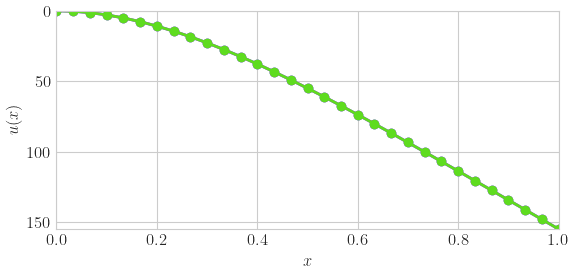

In [73]:
from matplotlib import pyplot
pyplot.style.use('../../../../qmcpy.mplstyle') #may need to be changed to find path to document in QMCSoftware folder
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(x_values, solution,'-o')
ax.plot(x_values, data.comb_bound_low,'-o')
ax.plot(x_values, data.comb_bound_high,'-o')
ax.set_xlim([0,len(solution)-1]); ax.set_xlabel(r'$x$') #[0,1] -- L=31 internals
ax.set_ylim([max(solution), min(solution)]);  ax.set_ylabel(r'$u(x)$');

## Parallel Evaluation

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `paralle=os.cpu_count()`.

In [27]:
import os
print('Available CPUs: %d'%os.cpu_count())

Available CPUs: 8


In [81]:
integrand = qp.UMBridgeWrapper(distribution_mul,model,umbridge_config,parallel=8,tf_input_to_umbridge_input = lambda t: t)
start_time = time.time()
solution,data = qp.CubQMCNetG(integrand,abs_tol=10).integrate()
end_time = time.time()
print(end_time - start_time)
data

3.421820640563965


LDTransformData (AccumulateData Object)
    solution        [  0.      0.344   1.329 ... 140.952 147.811 154.672]
    comb_bound_low  [  0.      0.344   1.329 ... 140.951 147.811 154.671]
    comb_bound_high [  0.      0.344   1.329 ... 140.952 147.811 154.672]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  3.422
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Gaussian (TrueMeasure Object)
    mean            [150. 150. 150. ... 150. 150. 150.]
    covariance      [[0.01  0.01  0.01  ... 0.002 0.002 0.001]
                    [0.01  0.01  0.01  ... 0.002 0.002 0.002]
                    [0.01  0.01  0.01  ... 0.002 0.002 0.002]
                    ...
                    [0.002 0.002 0.002 ... 0.01  0.01  0.01 ]
                    [0.002 0.0

## Shut Down Docker Image

In [239]:
!docker rm -f muqbp_new

muqbp_new


## Testbed

In [7]:
#from http://g2s3.com/labs/notebooks/EulerBernoulliLoads.html and GenerateObservations.py
priorVar = 10*10
priorLength = 0.5
priorNu = 3.0/2.0 # must take the form N+1/2 for zero or odd N (i.e., {0,1,3,5,...})

kern1 = ma.MaternKernel(1, 1.0, priorLength, priorNu)
kern2 = ma.ConstantKernel(1, priorVar)
kern = kern1 + kern2

dim =1
coDim = 1 # The dimension of the load field at a single point
mu = ma.ZeroMean(dim,coDim)

priorGP = ma.GaussianProcess(mu,kern)

plt.figure(figsize=(14,6))

numSamps = 3
for i in range(numSamps):
    samp = priorGP.Sample(x)
    plt.plot(x[0,:], samp[0,:], linewidth=2)
    
plt.xlabel('Position',fontsize=16)
plt.ylabel('Load',fontsize=16)
plt.show()

TypeError: Matern.__init__() got multiple values for argument 'length_scale'

In [14]:
def f(x):
    return x

sampler2 = qp.Lattice(1)
integrand2 = qp.CustomFun(qp.Uniform(sampler2), f)
qmc_stop_crit2 = qp.CubQMCLatticeG(integrand2,abs_tol = 10, ptransform = 'C3SIN') # QMC STOPPING CRITERION
#relevant adjustable criteria: tolerance, ptransform (when stopping criteria = lattice)
solution2,data2 = qmc_stop_crit2.integrate()
print(data)

LDTransformData (AccumulateData Object)
    solution        0.478
    comb_bound_low  0.478
    comb_bound_high 0.478
    comb_flags      1
    n_total         2^(10)
    n               2^(10)
    time_integrate  0.022
CubQMCLatticeG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     0
    upper_bound     1
Lattice (DiscreteDistribution Object)
    d               1
    dvec            0
    randomize       1
    order           natural
    gen_vec         1
    entropy         107990309957717245066407476466898578162
    spawn_key       ()


In [72]:
output_dimension = 7
sampler3 = qp.Lattice(output_dimension)
coeff = np.zeros(output_dimension) #[1, 1, 1, 0, 0, ..., 0]
coeff[0:4] = 1

pi = np.pi
#phi: R --> R
C1SIN = lambda x: x - np.sin(2 * pi * x) / (2 * pi)
C1SIN_weight = lambda x: 2 * np.sin(pi * x) ** 2
baker = lambda x: 1 - 2 * abs(x - 1 / 2)
baker_weight = lambda x: 1

phi_funcs = np.full(output_dimension, baker)
phi_funcs[0:2] = C1SIN
#print(phi_funcs)
w_funcs = np.full(output_dimension, baker_weight)
w_funcs[0:2] = C1SIN_weight

def f(x): #plain baker
    out = 1
    for j in range(output_dimension):
        out = out * (1 + coeff[j] * baker(x[j]) ** 2)
    return out

def g(x): #partial C1SIN + baker
    out = 1
    for j in range(output_dimension):
        out = out * (1 + coeff[j] * (phi_funcs[j](x[j])**2)) * w_funcs[j](x[j])
    return out

true_value = np.prod(1 + coeff / 3)
"""
distribution_mul, sampler = E_generator(sampler3)
integrand3 = qp.CustomFun(qp.Uniform(sampler3), f)
stop_crit3 = qp.CubQMCLatticeG(integrand3, abs_tol = 10, ptransform = 'NONE')
integrand4 = qp.CustomFun(qp.Uniform(sampler3), g)
stop_crit4 = qp.CubQMCLatticeG(integrand4, abs_tol = 10, ptransform = 'NONE')

solution3, data3 = stop_crit3.integrate()
solution4, data4 = stop_crit4.integrate()
print(data3)
print(data4)
"""
points = sampler3.gen_samples(1024)
avg_f = np.mean([f(p) for p in points])
avg_g = np.mean([g(p) for p in points])
print(abs(true_value - avg_f)) #f error
print(abs(true_value - avg_g)) #g error
#it seems like as soon as we incorporate some baker into g, f has lower error than g

0.00022927775938574868
0.0008540751535326407


In [17]:
sampler3.gen_samples(4)

array([[0.04226628, 0.94062721, 0.95186367, 0.99320756, 0.89152466,
        0.0821347 , 0.34994152, 0.51697455, 0.2437795 , 0.13495747,
        0.87110609, 0.0300137 , 0.85843473, 0.82828949, 0.07829743,
        0.66728596, 0.2247332 , 0.4094768 , 0.62891762, 0.25302738,
        0.39906025, 0.22450384, 0.623328  , 0.75366584, 0.01190172,
        0.21889945, 0.59292087, 0.83194548, 0.47449773, 0.37158266,
        0.97638879],
       [0.54226628, 0.44062721, 0.45186367, 0.49320756, 0.39152466,
        0.5821347 , 0.84994152, 0.01697455, 0.7437795 , 0.63495747,
        0.37110609, 0.5300137 , 0.35843473, 0.32828949, 0.57829743,
        0.16728596, 0.7247332 , 0.9094768 , 0.12891762, 0.75302738,
        0.89906025, 0.72450384, 0.123328  , 0.25366584, 0.51190172,
        0.71889945, 0.09292087, 0.33194548, 0.97449773, 0.87158266,
        0.47638879],
       [0.29226628, 0.69062721, 0.70186367, 0.24320756, 0.14152466,
        0.8321347 , 0.59994152, 0.26697455, 0.4937795 , 0.88495747,
      